In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go




from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/training_cleaned.csv')
df.drop(df.columns[0], axis=1, inplace=True)

In [0]:
df_clus = df.drop(columns=['RefId',
        'PurchDate',
        'IsBadBuy',
        'Auction',
        'Make',
        'Model',
        'WheelTypeID',
        'Nationality',
        'Size',
        'Color',
        'Transmission',
        'BYRNO',
        'TopThreeAmericanName',
        'SubModel',
        'VehicleAge',
        'IsOnlineSale',
        'Region',
        'IsBase',])
df_clus.dropna(inplace=True)

In [0]:
df_1 = df_clus[['AuctionAVG', 'RetailAVG', 'VehBCost']]
df_2 = df_clus[['WarrantyCost', 'Trend', 'VehBCost']]
df_3 = df_clus[['WarrantyCost', 'VehOdo', 'VehBCost']]

In [0]:
from sklearn.cluster import DBSCAN

In [0]:
to_db_scan = [df_1, df_2, df_3]
min_samp = []
epsilon = []
scaled_df = []
scaler = MinMaxScaler()

for i in range(3, 15):
  min_samp.append(math.pow(2, i))
  epsilon.append(0.01)

for e in to_db_scan:
  scaled_df.append(scaler.fit_transform(e.values))

In [8]:
results = {}

for i, e in enumerate(scaled_df):
  results[str(i)] = []

for i, df in enumerate(scaled_df):
  for j, ms in enumerate(min_samp):
    results[str(i)].append(DBSCAN(eps=epsilon[j], min_samples=ms).fit(scaled_df[0]))

  print("end ", i)

end  0
end  1
end  2


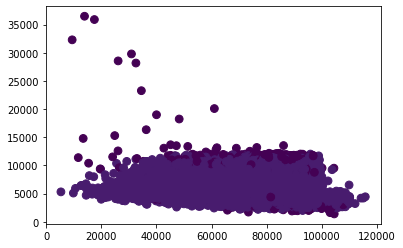

In [9]:
plt.scatter(df_clus['VehOdo'], df_clus['VehBCost'], 
            c=results['0'][0].labels_, s=60)

In [10]:
for i, df in enumerate(scaled_df):
  print("data frame ", str(i), ":")
  for j, ms in enumerate(min_samp):
    print(np.unique(results[str(i)][j].labels_, return_counts=True))
  print("========================================")

data frame  0 :
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 1086, 56803,    30,     7,     8,     2,    11,     6,    18,
           9,    15,     6,     6,     6]))
(array([-1,  0,  1,  2,  3]), array([ 2070, 55856,    30,    41,    16]))
(array([-1,  0,  1,  2,  3]), array([ 4220, 35019, 18694,    59,    21]))
(array([-1,  0,  1,  2]), array([ 7842, 32396, 17656,   119]))
(array([-1,  0,  1]), array([15953, 26725, 15335]))
(array([-1,  0,  1]), array([26247, 19582, 12184]))
(array([-1,  0,  1]), array([52964,  1167,  3882]))
(array([-1]), array([58013]))
(array([-1]), array([58013]))
(array([-1]), array([58013]))
(array([-1]), array([58013]))
(array([-1]), array([58013]))
data frame  1 :
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 1086, 56803,    30,     7,     8,     2,    11,     6,    18,
           9,    15,     6,     6,     6]))
(array([-1,  0,  1,  2,  3]), array([ 2070, 55856,    30,    41,    16]))
(array([-1,  0,  

In [11]:
filtered = []

for i, df in enumerate(scaled_df):
  for j, ms in enumerate(min_samp):
   labels, count = np.unique(results[str(i)][j].labels_, return_counts=True)
   if len(count) > 2: # len 0 => solo noise points, len => un solo cluster e noise points
    good_cluster_count = 0
    for punt, e in enumerate(labels):
      if e != -1 and count[punt] > 100:
        good_cluster_count += 1
    if good_cluster_count > 1 and count[0] < 10000:
      filtered.append({
          'df': i,
          'eps': epsilon[j], 
          'min_samp': ms,
          'labels': labels,
          'count': count
      })

print("========================================")
print("Found ", len(filtered), " potentially good clustering results")
print("========================================")
for e in filtered:
  print("data frame ", e['df'], " (<eps, min_samp> = <", e['eps'], ",", e['min_samp'], ">) -> ", e['count'])

Found  6  potentially good clustering results
data frame  0  (<eps, min_samp> = < 0.01 , 32.0 >) ->  [ 4220 35019 18694    59    21]
data frame  0  (<eps, min_samp> = < 0.01 , 64.0 >) ->  [ 7842 32396 17656   119]
data frame  1  (<eps, min_samp> = < 0.01 , 32.0 >) ->  [ 4220 35019 18694    59    21]
data frame  1  (<eps, min_samp> = < 0.01 , 64.0 >) ->  [ 7842 32396 17656   119]
data frame  2  (<eps, min_samp> = < 0.01 , 32.0 >) ->  [ 4220 35019 18694    59    21]
data frame  2  (<eps, min_samp> = < 0.01 , 64.0 >) ->  [ 7842 32396 17656   119]


**Knee Method**

In [0]:
from scipy.spatial.distance import pdist
from itertools import combinations

In [0]:
def square_to_condensed(i, j, n):
    assert i != j, "no diagonal elements in condensed matrix"
    if i < j:
        i, j = j, i
    return n*j - j*(j+1)/2 + i - 1 - j

Dobbiamo usare quella condensed perchè altrimenti non entra in memoria :(

In [0]:
to_knee = []
# to_knee = scaled_df

for df_i, df in enumerate(to_knee):
  dist = []
  dist = (pdist(df, metric='euclidean'))  #distance vector (condensed matrix)
  kth_distances = []
  n = len(df_1)
  for i in range (0, n):
    d = []
    for j in range (0, n):
      if i != j:
        idx = round(square_to_condensed(i, j, n))
        d.append(dist[idx])
    index_kth_distance = np.argsort(d)[5]
    kth_distances.append(d[index_kth_distance])
    if i % 1000 == 0:
      print("data frame ", df_i, ": ", i, " out of ", n)

  plt.clf()
  xLab = "Points sorted according to distance from " + str(
      5) + "th nearest neighbour"
  yLab = str(5) + "th nearest neighbour distance"
  plt.xlabel(xLab)
  plt.ylabel(yLab)
  plt.yticks(np.arange(0, 2, 0.1))
  ax = plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
  plt.grid(color='black', linestyle='-', linewidth=1)
  plt.show()

In [0]:
silu = {}
to_silu = []
#to_silu = scaled_df

for idx, e in enumerate(to_silu):
  silu[str(idx)] = []

for idx, e in enumerate(to_silu):
  for i, p in enumerate(min_samp):
    silu[str(idx)].append(silhouette_score(e, results[str(idx)][i].labels_, metric = 'euclidean'))
  print("end data frame ", idx)